# Variational inference for diffusion processes

Typically, the posterior of stochastic differential equation (SDE) models cannot be computed in closed form. Therefore, if are modelling some temporal data using an SDE, and are looking to compute the posterior of the model, we will have to resort to approximations. Here we discuss a method {cite}`archambeau2007gaussian` {cite}`archambeau2008variational` for approximating the posterior of an SDE, by fitting another approximating SDE to it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import HTML, set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
# css_style = open('../../../_static/custom_style.css', 'r').read()
# HTML(f'<style>{css_style}</style>')

/home/prakhar/anaconda3/envs/markovflow/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  """


## Two SDE models

Suppose we wish to model some data using an SDE with noisy observations of the form

$$\begin{align}
dx &= f(x, t) dt + \Sigma d\beta\\
y &\sim \mathcal{N}(0, r^2 I).
\end{align}$$

where $\beta$ is a standard Brownian motion. Given observations $\mathcal{D} = \{t_k, y_k\}_{k = 1}^K$, we are interested in approximating the posterior process $p(x, t | \mathcal{D})$. For most choices of $f(x, t)$, working with this SDE analytically is be impossible. Instead, we will approximate the posterior of this SDE with another stochastic process, described by the SDE

$$\begin{align}
dx &= g(x, t) dt + \Sigma d\beta, \text{ where } g(x, t) = -A(t)x(t) + b(t).
\end{align}$$

The motivation behind this particular form is that because this SDE is linear, it corresponds to a Gaussian Process (GP) whose marginal mean and variance can be treated almost entirely in analytic form. In particular, this mean and variance can be shown to exactly obey two ODEs which, even though cannot be solved in closed form, can be well approximated using numerical integration.

## Free Energy approximation

Because the approximating SDE has an affine drift function $g$ and a constant noise term, it is a Gaussian Process (GP). The marginal mean and variance, $m(t)$ and $S(t)$, of this GP statisfy{cite}`sarkka2019applied` the ODEs

$$\begin{align}
\dot{m}(t) &= -A(t)m(t) + b(t), \\
\dot{S}(t) &= -A(t)S(t) -S(t)A(t)^\top + \Sigma.
\end{align}$$

We are therefore interested finding $A(t)$ and $b(t)$ such that the distribution of $x$ under this SDE, approximates the distribution of $x$ under the posterior process. Let us write $q(x, t)$ for the distribution of $x$ at time $t$ according to the approximating SDE and $p(x, t)$ for the prior of the exact SDE - we will often abbreviate these by $q(x)$ and $p(x)$. We will fit $A, b$ by minimising the free energy

$$\begin{align}
\mathcal{F}(A, b) &= \sum_{k = 1}^K \int q(x_k) \log p(y_k | x_k) dx_k - KL\left[q || p\right].
\end{align}$$

We cannot compute this free energy in closed form, so we approximate it with a discretisation. Then letting the discretisation resolution go to $0$ we come close to an analytic expression for the KL-divergence between the prior and the approximating SDE.

<div class="lemma">
    
**Lemma (KL-divergence between $p$ and $q$)** The KL-divergence between the prior and approximating SDEs can be written as
    
$$\begin{align}
KL\left[q || p\right] &= KL\left[q(x_0) || p(x_0)\right] + \frac{1}{2}\int^{t_1}_{t_0} \int q(x_n) (f(x, t) - g(x, t))^\top \Sigma^{-1}(f(x, t) - g(x, t)) dx_n dt. \\
\end{align}$$
    
</div>
<br>

<details class="proof">
<summary>Proof: KL-divergence between \(p\) and \(q\)</summary>

<div>
    
Consider splitting the time interval $[t_0, t_1]$ into $N$ equal segments of size $\Delta t = \frac{t_1 - t_0}{N}$ and let the values of the SDE at the endpoints of these segments be $x_0, x_1, ..., x_N$. Then, the joint distribution at these points in time under the prior and approximating SDEs are

$$\begin{align}
p(x_0, ..., x_N) &\approx p(x_0) \prod_{n = 1}^N \mathcal{N}(x_{n+1} | x_n + f_n \Delta t, \Sigma \Delta t), \\
q(x_0, ..., x_N) &\approx p(x_0) \prod_{n = 1}^N \mathcal{N}(x_{n+1} | x_n + g_n \Delta t, \Sigma \Delta t).
\end{align}$$
    
We can then write the KL-divergence between these two multivariate distributions as    
    
$$\begin{align}
&KL[q(x_0, ..., x_N) || p(x_0, ..., x_N)] = \\
=~&KL\left[q(x_0) || p(x_0)\right] - \sum_{n = 1}^N \int\int q(x_{n+1}, x_n) \left[\log p(x_{n+1} | x_n) - \log q(x_{n+1} | x_n)\right]~dx_n dx_{n+1}~.
\end{align}$$
    
Evaluating the second term and taking the $\Delta t \to 0$ limit we obtain
    
$$\begin{align}
& \sum_{n = 1}^N \int\int q(x_{n+1}, x_n) \left[\log p(x_{n+1} | x_n) - \log q(x_{n+1} | x_n)\right]~dx_n  =\\
&= \frac{1}{2}\sum_{n = 1}^N \int\int q(x_{n+1}, x_n) \big[(x_{n+1} - x_n - f_n \Delta t)^\top (\Sigma \Delta t)^{-1}(x_{n+1} - x_n - f_n \Delta t) \\
&~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ - (x_{n+1} - x_n - g_n \Delta t)^\top (\Sigma \Delta t)^{-1}(x_{n+1} - x_n - g_n \Delta t) \big] ~dx_n dx_{n+1} \\
&= \frac{1}{2}\sum_{n = 1}^N \int q(x_{n+1}, x_n) \text{Tr}\big[(x_{n+1} - x_n - f_n \Delta t)(x_{n+1} - x_n - f_n \Delta t)^\top (\Sigma \Delta t)^{-1} \\
&~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ - (x_{n+1} - x_n - g_n \Delta t)(x_{n+1} - x_n - g_n \Delta t)^\top (\Sigma \Delta t)^{-1} \big] ~dx_n dx_{n+1} \\
&= \frac{1}{2}\sum_{n = 1}^N \int q(x_n) (f_n - g_n)^\top \Sigma^{-1}(f_n - g_n) dx_n \\
&\to \frac{1}{2}\int^{t_1}_{t_0} \int q(x_n) (f_n - g_n)^\top \Sigma^{-1}(f_n - g_n) dx_n dt.\\
\end{align}$$
 
</div>

</details>
<br>


Therefore, the free energy is equal to

$$\begin{align}
\mathcal{F}(\theta, A, b) &= \sum_{k = 1}^K \int q(x_k) \log p(y_k | x_k) dx_k + KL\left[q || p\right] \\
&= \sum_{k = 1}^K \int_{t_0}^{t_1} \underbrace{\int q(x_k) \log p(y_k | x_k) dx_k}_{= E_{obs}} \delta(t - t_k) dt + \\
&~~~~~+  \int^{t_1}_{t_0} \underbrace{\frac{1}{2}\int q(x_n) (f_n - g_n)^\top \Sigma^{-1}(f_n - g_n) dx_n}_{= E_{sde}} dt + KL\left[q(x_0) || p(x_0)\right],
\end{align}$$

and we look to optimise this w.r.t. $A, b$.

## Maximising the Free Energy

Maximising $\mathcal{F}$ w.r.t. $A, b$ directly is tricky because $m, S$ depend on $A, b$. Changing $A, b$ will change $m, S$ in a complicated nonlinear way and we would have to account for this when computing the gradients of $\mathcal{F}$ w.r.t. $A, b$. More specifically, since the approximating SDE is linear, its mean $m(t)$ and covariance $S(t)$ exactly follow

$$\begin{align}
\dot{m}(t) &= -A(t)m(t) + b(t), \\
\dot{S}(t) &= -A(t)S(t) - S(t)A^\top(t) + \Sigma,
\end{align}$$

linking the values of $m, S$ at later times, to the values of $A, b$ at earlier times. To avoid having to compute these gradients explicitly, we can treat the $m, S, A, b$ variables as independent and instead introduce the ODEs above as constraints to the optimisation problem. This means that any solution found by our optimisation problem will respect these constraints and $m, S, A, b$ will be consistent. Introducing Lagrange mulitpliers $\lambda$ (a vector) and $\Psi$ (a symmetric matrix), enforcing these constraints, we can write the Lagrangian $\mathcal{L}$ as

$$\begin{align}
\mathcal{L} = \mathcal{F}(\theta, A, b) - \int_{t_0}^{t_1} \lambda^\top(t)(\dot{m}(t) + A(t)m(t) - b(t)) dt - \int_{t_0}^{t_1} \text{Tr}\left[\Psi(t)(\dot{S}(t) + 2A(t)S(t) - \Sigma)\right] dt.
\end{align}$$

Note that $\lambda(t_1)$ and $\Psi(t_1)$ can be set to $0$ since we only need the ODE constraints to be satisfied for $t_0 \leq t < t_1$. Taking variational derivatives, we obtain the four equations presented below - we ommit dependence on $t$ to lighten the notation. The first two equations are

$$\begin{align}
\nabla_A \mathcal{L} &= \frac{\partial E_{sde}}{\partial A} - \lambda^\top - 2\Psi S, \\
\nabla_b \mathcal{L} &= \frac{\partial E_{sde}}{\partial b} + \lambda.
\end{align}$$

and give the gradients of the Lagrangian with respect to $A, b$. Taking variational derivatives and setting these equal to $0$ we obtain the ODEs for $\lambda$ and $\Psi$ below

$$\begin{align}
\nabla_m \mathcal{L} &= \dot{\lambda} + \frac{\partial E_{sde}}{\partial m} + \frac{\partial E_{obs}}{\partial m} - A^\top \lambda = 0, \\
\nabla_S \mathcal{L}  &= \dot{\Psi} + \frac{\partial E_{sde}}{\partial S} + \frac{\partial E_{obs}}{\partial S} - 2\Psi A = 0.
\end{align}$$

Now in order to optimise the Lagrangian, we first solve forwards for $m, S$ given $A, b$ and initial conditions $m(t_0) = m_0, S(t_0) = S_0$. Then we then solve backwards for $\lambda(t), \Psi(t)$ for given $m(t), S(t)$ and $A(t), b(t)$ with initial conditions $\lambda(t_1) = 0, \Psi(t_1) = 0$. Lastly we compute the gradients $\nabla_A \mathcal{L}$ and $\nabla_b \mathcal{L}$ and adjust $A, b$ by taking a gradient step,{cite}`archambeau2008variational` that is

$$\begin{align}
A &\leftarrow A - \eta \nabla_A \mathcal{L} = \frac{\partial E_{sde}}{\partial A} - \lambda^\top - 2\Psi S, \\
b &\leftarrow b - \eta \nabla_b \mathcal{L} = \frac{\partial E_{sde}}{\partial b} + \lambda.
\end{align}$$

Alternatively,{cite}`archambeau2008variational` we can equate these gradients to $0$ and solve for $A, b$, giving a new set of parameters $\tilde{A}, \tilde{b}$

$$\begin{align}
A &\leftarrow (1 - \omega) A - \omega \tilde{A} &\text{where } \tilde{A} \text{ satisfies } \nabla_A \mathcal{L}\big|_{\tilde{A}} = 0 \\
b &\leftarrow (1 - \omega) b - \omega \tilde{b} &\text{where } \tilde{b} \text{ satisfies } \nabla_b \mathcal{L}\big|_{\tilde{b}} = 0 .
\end{align}$$

## Implementation

We now implement the algoritm, breaking it into a forward solve, a backward solve and a helper which interleaves these two steps a number of times. We will apply the algorithm to the [Ornstein-Uhlenbeck](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process) SDE with a 

$$\begin{align}
dx &= -\gamma x dt + \sigma dt, \\
y &\sim \mathcal{N}(x, r^2), \\
\end{align}$$

This model was used in {cite}`archambeau2007gaussian`, because its posterior is available in closed form, since it corresponds to a GP with zero mean and covariance function

$$\begin{align}
k(x, x') = \frac{\sigma^2}{2\gamma} e^{-\gamma|x - x'|}.
\end{align}$$

### The forward step

In the forward step we solve the ODEs

$$\begin{align}
\dot{m}(t) &= -A(t)m(t) + b(t), \\
\dot{S}(t) &= -A(t)S(t) - S(t)A^\top(t) + \Sigma,
\end{align}$$

numerically for $m, S$ of the approximating SDE, using the Euler method. Since the forward solve is independent of the SDE being approximated, none of the details of the OU SDE enter the `forward` function.

In [2]:
def forward(m, S, b, A, Sigma, dt):
    
    for i in range(len(b) - 1):
        
        # Euler step for m and S ODEs
        m[i + 1] = m[i] - (np.dot(A[i], m[i]) - b[i]) * dt
        S[i + 1] = S[i] - (np.dot(A[i], S[i]) + np.dot(S[i], A[i].T) - Sigma) * dt
        
    return m, S

### The backward step

In the backward step we first solve the ODEs

$$\begin{align}
\dot{\lambda} = \frac{\partial E_{sde}}{\partial m} - \frac{\partial E_{obs}}{\partial m} + A^\top \lambda = 0, \\
\dot{\Psi} = \frac{\partial E_{sde}}{\partial S} - \frac{\partial E_{obs}}{\partial S} + 2\Psi A = 0,
\end{align}$$

and then compute the variational derivatives w.r.t. $A, b$ and set these to zero to compute the updates $\tilde{A}, \tilde{b}$

$$\begin{align}
\nabla_A \mathcal{L} &= \frac{\partial E_{sde}}{\partial A} - \lambda^\top - 2\Psi S  = 0, \\
\nabla_b \mathcal{L} &= \frac{\partial E_{sde}}{\partial b} + \lambda = 0.
\end{align}$$

For this SDE, the $E_{sde}$ and $E_{obs}$ quantities are

$$\begin{align}
E_{sde} &= (m^2 + S) \frac{(\alpha - \gamma)^2}{2\sigma^2} - bm\frac{\alpha - \gamma}{2\sigma^2} + \frac{b^2}{2\sigma^2}, \\
E_{obs} &= \frac{m^2 + S}{2r^2} - \frac{ym}{r^2} + \frac{y^2}{2r^2}.
\end{align}$$

Note that because observation term of the free energy involves $\delta$-functions at the locations where observations are present, the following jump conditions must be applied at these locations

$$\begin{align}
\lambda(t_k^+) &= \lambda(t_k^-) - \frac{\partial E_{obs}}{\partial m}, \\
\Psi(t_k^+) &= \Psi(t_k^-) - \frac{\partial E_{obs}}{\partial S}.
\end{align}$$

In [3]:
def backward(t_grid, A, b, m, S, Sigma, gamma, r, psi, lamda, t_dict, x, dt):
    
    # Arrays for storing the updates for A and b
    A_ = np.zeros_like(A)
    b_ = np.zeros_like(b)

    for i in range(len(b) - 1, 0, -1):
        
        # Compute dEdS and dEdm
        coeff = (A[i] - gamma) ** 2 / Sigma
        dEdS = 0.5 * coeff
        dEdm = coeff * m[i] - b[i] * (A[i] - gamma) / Sigma
        
        # Euler step for lambda and psi ODEs
        lamda[i - 1] = lamda[i] - (np.dot(A[i].T, lamda[i]) - dEdm) * dt
        psi[i - 1] = psi[i] - (2 * np.dot(psi[i], A[i]) - dEdS) * dt
        
        # Handle jump conditions at locations of the data
        if t_grid[i - 1] in t_dict:
            psi[i - 1] = psi[i - 1] + 0.5 * r ** -2
            lamda[i - 1] = lamda[i - 1] - r ** -2 * (x[t_dict[t_grid[i - 1]]] - m[i - 1])
            
    for i in range(len(b) - 1, -1, -1):
        A_[i] = gamma + 2 * np.dot(Sigma, psi[i])
        b_[i] = - gamma * m[i] + np.dot(A_[i], m[i]) - np.dot(Sigma, lamda[i])
        
    return psi, lamda, b_, A_

### Putting the two together

The `smoothing` function below puts the forward and backward steps together, executing them in an interleaved fashion for a specified number of times.

In [4]:
def smoothing(t_obs, t_grid, y_obs, num_passes, omega, Sigma, gamma, r, dt, m0, S0):
    
    grid_size = t_grid.shape[0]
    
    # Dictionary mapping from times to indices for array x
    t_dict = dict(zip(t_obs, np.arange(0, len(t_obs))))
    
    b = np.zeros((grid_size, 1))
    A = np.zeros((grid_size, 1, 1))
    
    for i in range(num_passes):

        lamda = np.zeros((grid_size, 1))
        psi = np.zeros((grid_size, 1, 1))

        m = m0 * np.ones((grid_size, 1))
        S = S0 * np.ones((grid_size, 1, 1))
        
        # Forward pass to compute m, S
        m, S = forward(m=m, S=S, b=b, A=A, Sigma=Sigma, dt=dt)
        
        # Backward pass to compute psi, lamda, b_, A_
        psi, lamda, b_, A_ = backward(t_grid=t_grid,
                                      A=A,
                                      b=b,
                                      m=m,
                                      S=S,
                                      Sigma=Sigma,
                                      gamma=gamma,
                                      r=r,
                                      psi=psi,
                                      lamda=lamda,
                                      t_dict=t_dict,
                                      x=y_obs,
                                      dt=dt)
        
        b = b + omega * (b_ - b)
        A = A + omega * (A_ - A)

    return b, A, m, S, psi, lamda

## Demonstration

We now apply the algorithm to toy data drawn from the exact GP model, shown below.

In [5]:
import numpy as np
from matplotlib import pyplot as plt

In [6]:
def ornstein_uhlenbeck(sigma, gamma, t, t_):
    
    coeff = 0.5 * sigma ** 2 / gamma
    exp = np.exp(- gamma * np.abs(t[..., :, None] - t_[..., None, :]))
    
    return coeff * exp

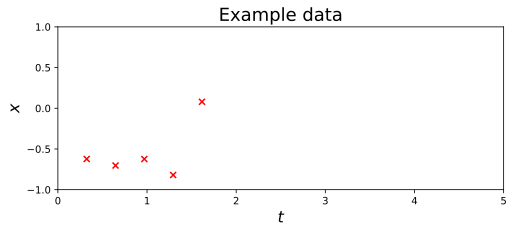

In [7]:
# Initial and final time to approximate
t0 = 0.
t1 = 2.

# OU parameters sigma and gamma, and observation noise level
sigma = 1.
gamma = 2.
r = 1e-1

# Number of observations and integration grid size
num_obs = 5
grid_size = 100

# Number of grid points between observation points
interval_size = int(grid_size / (num_obs + 1) - 1e-6)

# Grid of times used for integration and grid of times for observations
t_grid = np.linspace(t0, t1, grid_size)
t_obs = t_grid[::interval_size][1:-1]

# Set random seed 
np.random.seed(1)

# Zero mean vector and OU covariance matrix for sampling from the SDE prior
y_mean = np.zeros((num_obs,))
y_cov = ornstein_uhlenbeck(sigma=sigma, gamma=gamma, t=t_obs, t_=t_obs)
y_cov = y_cov + r ** 2 * np.eye(num_obs)

y_obs = np.random.multivariate_normal(mean=y_mean, cov=y_cov)

# Plot data
plt.figure(figsize=(8, 3))
plt.scatter(t_obs, y_obs, marker='x', color='red', zorder=2)

# Format plot
plt.title('Example data', fontsize=18)
plt.xlabel('$t$', fontsize=16)
plt.ylabel('$x$', fontsize=16)
plt.xticks(np.linspace(0, 5, 6))
plt.yticks(np.linspace(-1, 1, 5))
plt.show()

In [8]:
# Algorithm parameters
num_passes = 200
Sigma = sigma ** 2 * np.eye(1)
omega = 0.001 #5e-1
m0 = 0.
S0 = 1e-1

dt = (t1 - t0) / grid_size

# Run the smoothing algorithm
b, A, m, S, psi, lamda = smoothing(t_obs=t_obs,
                                   t_grid=t_grid,
                                   y_obs=y_obs,
                                   num_passes=num_passes,
                                   omega=omega,
                                   Sigma=Sigma,
                                   gamma=gamma,
                                   r=r,
                                   dt=dt,
                                   m0=m0,
                                   S0=S0)

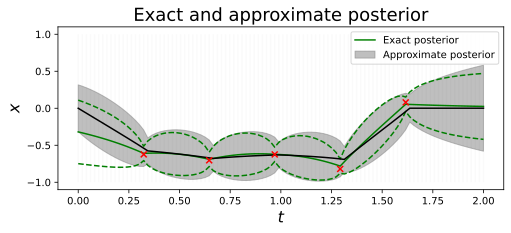

In [9]:
# Compute the exact posterior of the OU process
t_post = np.linspace(t0, t1, 100)

# Zero mean vector and OU covariance matrix for sampling from the SDE prior
Ktt = ornstein_uhlenbeck(sigma=sigma, gamma=gamma, t=t_obs, t_=t_obs)
Ktt = Ktt + r ** 2 * np.eye(num_obs)

Kt_t = ornstein_uhlenbeck(sigma=sigma, gamma=gamma, t=t_post, t_=t_obs)
Kt_t_ = ornstein_uhlenbeck(sigma=sigma, gamma=gamma, t=t_post, t_=t_post)

# Exact posterior mean and variance
post_mean = Kt_t @ np.linalg.solve(Ktt, y_obs)
post_var = np.diag(Kt_t_ - Kt_t @ np.linalg.solve(Ktt, Kt_t.T))

# Plot data, approximate and exact posterior
plt.figure(figsize=(8, 3))

# Observed data
plt.scatter(t_obs, y_obs, marker='x', color='red', zorder=3)

# Approximate posterior
plt.plot(t_grid, m[:, 0], color='k', zorder=2)
plt.vlines(t_grid.reshape(-1), -1, 1, alpha=0.02, color="black")
plt.fill_between(t_grid,
                 m[:, 0] - S[:, 0, 0] ** 0.5,
                 m[:, 0] + S[:, 0, 0] ** 0.5,
                 color='gray',
                 alpha=0.5,
                 zorder=1,
                 label='Approximate posterior')

# Exact posterior
plt.plot(t_post, post_mean, color='green', zorder=1, label='Exact posterior')
plt.plot(t_post, post_mean - post_var ** 0.5, '--', color='green', zorder=1)
plt.plot(t_post, post_mean + post_var ** 0.5, '--', color='green', zorder=1)

# Format plot
plt.title('Exact and approximate posterior', fontsize=18)
plt.xlabel('$t$', fontsize=16)
plt.ylabel('$x$', fontsize=16)
# plt.xticks(np.linspace(0, 5, 6))
plt.yticks(np.linspace(-1, 1, 5))
# plt.xlim([0, 5])
plt.legend()
plt.savefig("vgp_stratis.svg")
plt.show()

Note that since we did not optimise the initial mean and variance $m_0, S_0$, the approximate posterior does not precisely match the exact posterior. Overall however, the approximation looks quite good. This is expected since this was a relatively easy example, where the SDE being approximated was linear. It would be interesting to test this algorithm in scenarios where the underlying SDE is non-linear or when the posterior SDE is multimodal.

## Conclusions

The method presented in this page provides a way for approximating posteriors of constant-noise SDEs using a variational approach. To achieve this, the original SDE is approximated by a linear SDE with a time-varying diffusion function, adapted so that the approximate posterior minimises the free energy. One shortcoming of this method is that its computational complexity scales as $\mathcal{O}(T)$ with the time interval $T$. Moreover, as the solution must be performed numerically on a fine grid, this cost is far from negligible. Furthermore, this method does not currently support adaptive stepsize numerical ODE solvers, since the forward and backward steps require access to the value of related quantities on the same grid of points. Lastly, this approximation must be repeated for different datasets - it would be interesting to investigate whether amortisation can be incorporated into this method.

## References

```{bibliography} ./references.bib
```